In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.assumption_check as ac 
import src.data_collection as dc
import src.cleaning_data as cd

import warnings

warnings.filterwarnings('ignore')

## Inferential Modeling Workflow:

The King County Department of Assessments publishes Real Property Assessment data. The data can be downloaded from <a href="https://info.kingcounty.gov/assessor/DataDownload/default.aspx" target="_blank">here</a>. 

This project is aimed to address following questions:

1. Does higher square footage increase home sale price? 
2. Does having a porch increases home sale price?
3. Does having a beachfront or lakefront increase home sale price? 
5. Does the presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price?

The results of this analysis is expected to help real estate agents, house owners, or other audiences to have a better estimate of the houses.

### Step1 - Importing the data.

The data was cleaned and preprocessed already. The process is included in the clean_data.py file in the src folder.

In [55]:
king_house_2019 = cd.data_cleaned();

In [3]:
king_house_2019.head()

,Minor_x,ExciseTaxNbr,Major_x,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,AddnlCost,SqlTotalGarage,pwrlines,othernuisance,nuisance_total,nuisance_bool,is_waterfront,BathTotal,PorchTotal,is_porch
0,0120,3027422,213043,12/20/2019,560000.0,20191226000848,,,,,...,0,550.0,False,False,0.0,0,0,2.00,180.0,1
1,0630,3002257,940652,07/22/2019,435000.0,20190730001339,,,,,...,2500,465.0,False,False,0.0,0,0,2.50,45.0,1
5,0178,3014031,663990,10/04/2019,950000.0,20191007000828,,,,,...,0,660.0,False,False,0.0,0,0,2.50,60.0,1
10,0010,3012934,615490,09/24/2019,775000.0,20190930002488,,,,,...,0,0.0,False,False,0.0,0,0,1.75,0.0,0
12,0040,2982060,347050,04/04/2019,648500.0,,,,,,...,6000,590.0,False,False,0.0,0,0,2.50,0.0,0


### Step2 - Exploring the Data

##### Display descriptive statistics and visualize the relationship between the sale price and the features.

1. The first part shows the correlation among the outcome variable(sale price), and the interested continuous variables.
2. The second part shows the correlations between the outcome variable(sale price), and the interested categorical variables.

In [60]:
## Descriptive statistics of interested featrures and outcome variable.

king_house_2019[['SalePrice','SqFtTotLiving', 'BathTotal', 'SqlTotalGarage', 'LakeWashington', 'PorchTotal']].describe()

,SalePrice,SqFtTotLiving,BathTotal,SqlTotalGarage,LakeWashington,PorchTotal
count,1.987700e+04,19877.000000,19877.000000,19877.000000,19877.000000,19877.000000
mean,8.011641e+05,2141.391659,2.200508,350.242642,0.062082,77.904966
std,6.125291e+05,976.051905,0.822378,286.800631,0.411607,152.229680
min,6.500000e+04,250.000000,0.000000,0.000000,0.000000,0.000000
25%,4.725000e+05,1450.000000,1.750000,0.000000,0.000000,0.000000
50%,6.600000e+05,1960.000000,2.250000,400.000000,0.000000,40.000000
75%,9.100000e+05,2630.000000,2.500000,530.000000,0.000000,100.000000
max,1.605000e+07,11380.000000,13.000000,3210.000000,4.000000,11570.000000


#### Visualize the correlations

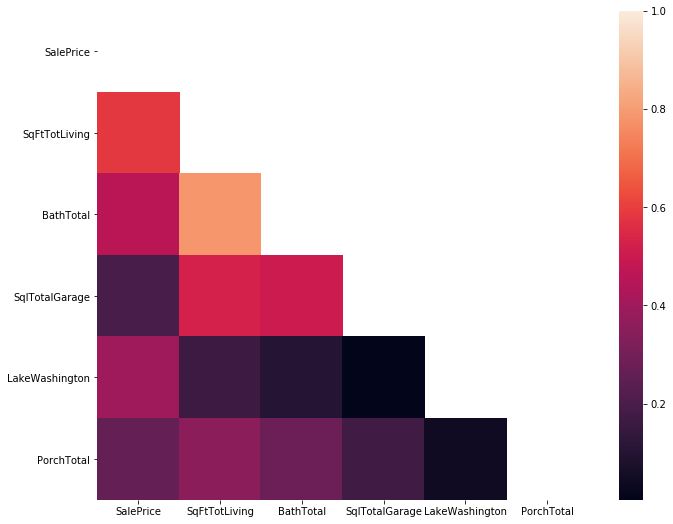

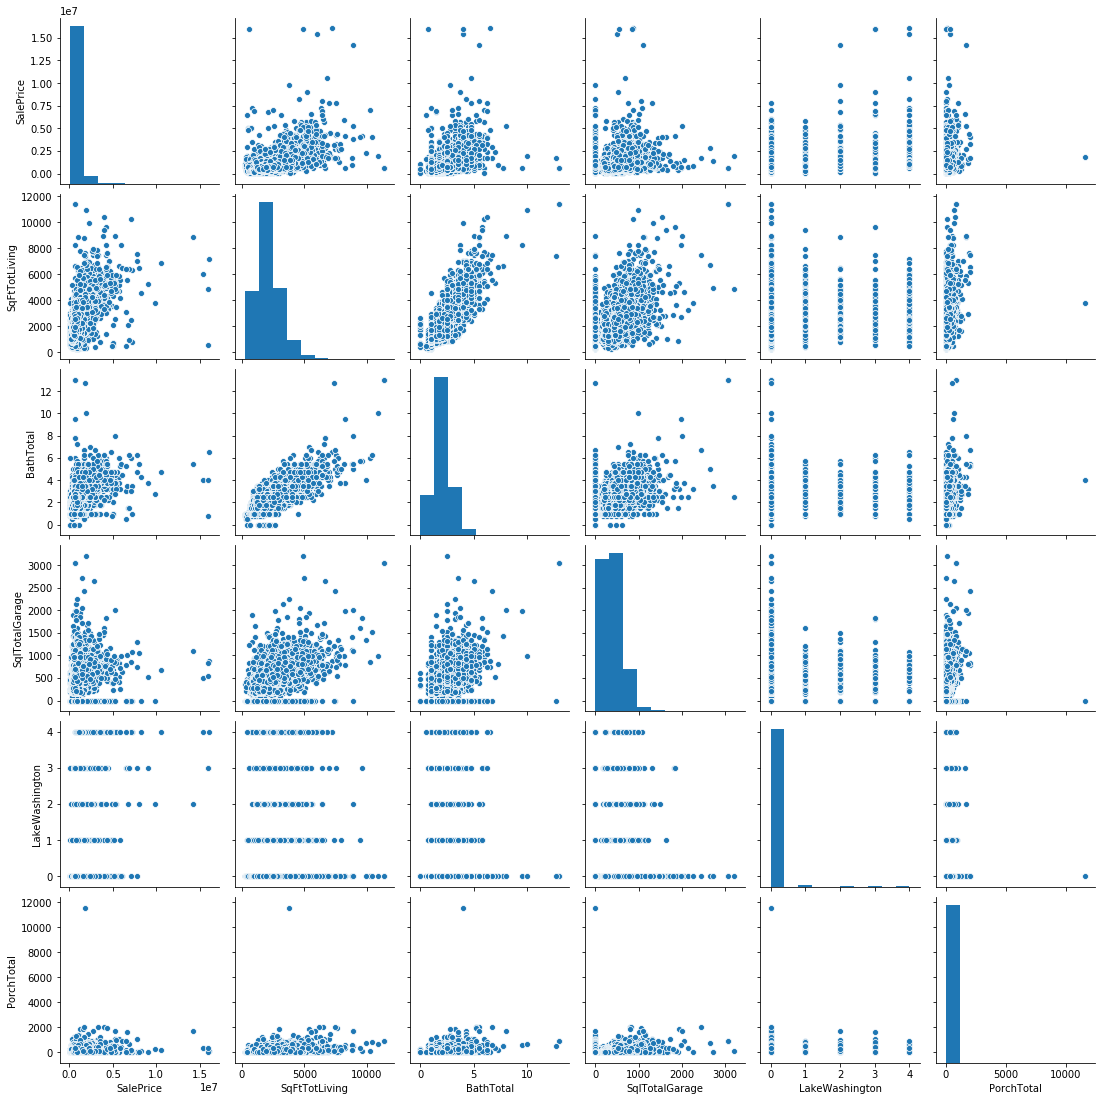

In [5]:
columns = ['SalePrice','SqFtTotLiving', 'BathTotal', 'SqlTotalGarage', 'LakeWashington', 'PorchTotal']
df = king_house_2019[columns]
colrelation = ac.correlation_fig(df)

#### Visualize the relationship between sale price and three categorical variables

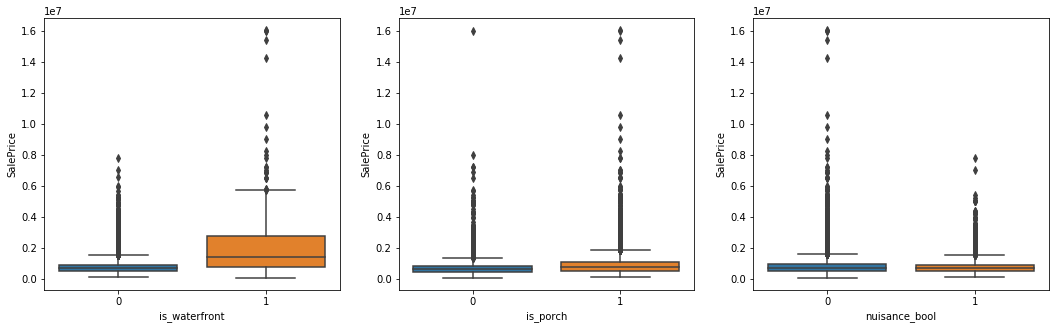

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x="is_waterfront", y="SalePrice", data=king_house_2019,  ax=axes[0])

sns.boxplot(x="is_porch", y="SalePrice", data=king_house_2019,  ax=axes[1])

sns.boxplot(x="nuisance_bool", y="SalePrice", data=king_house_2019,  ax=axes[2])

From the boxes above, it is obvious that the mean difference of the sale prices is not substantial for if having a porch or not, and for if having nuisance or not. 

### Step3 - Building Multiple Regression Model & Model Evaluation

The method of building the multiple regression model for this project is starting from a simple model with the most correlated feature based on the correlation visualization in the last step. Then, gradually add more new features interested features that help answer research questions.

The multiple linear regression analysis makes several key assumptions. The model evaluation is aimed to check these assumptions.

        Linearity:
        Linear regression assumes that the input variable linearly predicts the output variable.The Rainbow test is used to check the linearity, which is available from the diagnostic submodule of StatsModels

        Normality:
        Linear regression assumes that the residuals are normally distributed. It is possible to check this qualitatively with a Q-Q plot, but this example shows how to assess it statistically.
        The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).
        The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.

        Homoscadasticity:
        Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s). Homoscadasticity can be visualized by looking at the predicted life expectancy vs. the residuals.
        Homoscadasticity can also be tested by using the Breusch-Pagan test, which is available from the diagnostic submodule of StatsModels

        Independence:
        The independence assumption means that the independent variables must not be too collinear. When there is only one independent variable, don't need to check this yet.


### 3.1 - Base Model

The base model includes only one feature, 'SqFtTotLiving'

In [7]:
columns = ['SalePrice', 'SqFtTotLiving']
df = king_house_2019
kh_df0 = ac.create_df(df, columns)
kh_base_model = ac.create_model(kh_df0)

In [8]:
model_summary = ac.model_summary(kh_base_model)
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:27:59   Log-Likelihood:            -2.8887e+05
No. Observations:               19877   AIC:                         5.778e+05
Df Residuals:                   19875   BIC:                         5.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.235e+04   8481.150      1.456      0.145   -4272.999     2.9e+04
X            368.3648      3.604    102.213      0.000     361.301     375.429
==============================================================================
Omnibus:                    28937.039   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26926098.995
Skew:                           8.430   Prob(JB):                         0.00
Kurtosis:                     182.519   Cond. No.                     5.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Base Model Evaluation

In [9]:
## check linearity:

check = ac.linearity_check(kh_base_model)

Rainbow statistic: 0.9043001482476026
Rainbow p-value: 0.9999997317625994


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [10]:
## check Normality

ac.normality_check(kh_base_model)

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


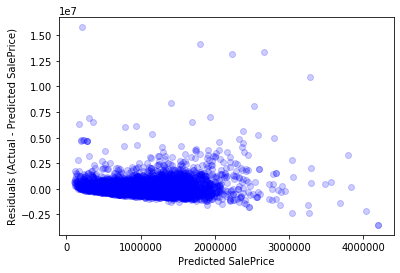

In [11]:
## Check homoscadisdicity

ac.homosdt_check_fig(kh_df0, kh_base_model)

In [12]:
ac.homosdt_check_test(kh_df0, kh_base_model)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.849712587303296e-59


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


##### Check Independence:

The independence assumption means that the independent variables must not be too collinear. If we have only one independent variable, so we don't need to check this.

#### Base model interpretation:

The base model explains 34.5% variance of the sale price by having only one feature. It was not bad. The results of the model evaluation are not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.2 - Model2: adds a new feature, SqlTotalGarage, the total squrefeet of the garage.

In [13]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage']
df = king_house_2019

kh_df2 = ac.create_df(df, columns)
model2 = ac.create_model(kh_df2)

In [14]:
ac.model_summary(model2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     5659.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:00   Log-Likelihood:            -2.8859e+05
No. Observations:               19877   AIC:                         5.772e+05
Df Residuals:                   19874   BIC:                         5.772e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.852e+04   8366.034      2.214      0.027    2122.903    3.49e+04
X[0]         421.1369      4.183    100.667      0.000     412.937     429.337
X[1]        -340.2670     14.237    -23.900      0.000    -368.173    -312.361
==============================================================================
Omnibus:                    29254.522   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29583587.516
Skew:                           8.591   Prob(JB):                         0.00
Kurtosis:                     191.215   Cond. No.                     5.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model2 Evaluation

In [15]:
ac.linearity_check(model2)

Rainbow statistic: 0.8954117211201682
Rainbow p-value: 0.9999999815037836


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [16]:
ac.normality_check(model2)

print("\n")
print(f"The Prob(JB) is < 0.01, therefore, the normality was violated.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


The Prob(JB) is < 0.01, therefore, the normality was violated.


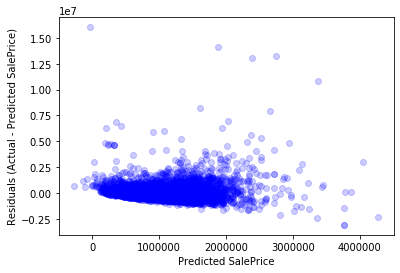

In [17]:
ac.homosdt_check_fig(kh_df2, model2)

In [18]:
ac.homosdt_check_test(kh_df2, model2)

Lagrange Multiplier p-value: 5.199653235906325e-60
F-statistic p-value: 4.384524943891508e-59


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [19]:
ac.independence_check(kh_df2)

        VIF         feature
0  3.450219   SqFtTotLiving
1  3.450219  SqlTotalGarage


VIF needs to be smaller than 5.


#### Model2 interpretation:

After adding a new feature, model explains 36.3% variance of the sale price. The explained variance was not increased sizebaly partly because the SqlTotalGarage is correlated with the SqFtTotLiving. The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.3 - Model3: Add new feature

In [20]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage', 'is_porch']
df = king_house_2019

kh_df3 = ac.create_df(df, columns)
model3 = ac.create_model(kh_df3)

In [21]:
ac.model_summary(model3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3773.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:00   Log-Likelihood:            -2.8859e+05
No. Observations:               19877   AIC:                         5.772e+05
Df Residuals:                   19873   BIC:                         5.772e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.913e+04   8485.673      2.254      0.024    2496.085    3.58e+04
X[0]         421.6223      4.334     97.275      0.000     413.127     430.118
X[1]        -340.2859     14.238    -23.900      0.000    -368.193    -312.379
X[2]       -3120.5322   7286.161     -0.428      0.668   -1.74e+04    1.12e+04
==============================================================================
Omnibus:                    29251.198   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29572128.926
Skew:                           8.589   Prob(JB):                         0.00
Kurtosis:                     191.178   Cond. No.                     6.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model3 Evaluation

In [22]:
ac.linearity_check(model3)

Rainbow statistic: 0.8953465091105429
Rainbow p-value: 0.9999999818670943


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [23]:
ac.normality_check(model3)
print("\n")
print(f"The Prob(JB) is < 0.01, therefore, the normality was violated.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


The Prob(JB) is < 0.01, therefore, the normality was violated.


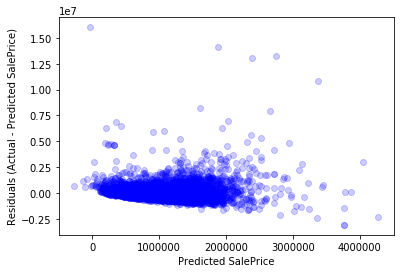

In [24]:
ac.homosdt_check_fig(kh_df3, model3)

In [25]:
ac.homosdt_check_test(kh_df3, model3)

Lagrange Multiplier p-value: 4.4623429688111935e-62
F-statistic p-value: 2.226700794632316e-61


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [26]:
ac.independence_check(kh_df3)

        VIF         feature
0  4.698117   SqFtTotLiving
1  3.450235  SqlTotalGarage
2  2.255310        is_porch


VIF needs to be smaller than 5.


#### Model3 interpretation:
After adding a new feature, model still explains 36.3% variance of the sale price. The p value of the coeeficient of is_porch is greater than 0.5 as well. It means if having a porch does not explain any variance in the sale price. This is probably because the data point is very spreadout. The boxplot above aslo showed that the mean difference between having a porch and not having a porch is very small. 

The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.4 - Model4: add is_waterfront as a new feature


In [27]:
columns = columns = ['SalePrice', 'SqFtTotLiving',  'SqlTotalGarage', 'is_porch', 'is_waterfront']

df = king_house_2019

kh_df4 = ac.create_df(df, columns)
model4 = ac.create_model(kh_df4)

In [28]:
ac.model_summary(model4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     3687.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:00   Log-Likelihood:            -2.8755e+05
No. Observations:               19877   AIC:                         5.751e+05
Df Residuals:                   19872   BIC:                         5.752e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.625e+04   8055.842      3.258      0.001    1.05e+04     4.2e+04
X[0]         400.6409      4.138     96.810      0.000     392.529     408.753
X[1]        -296.2790     13.547    -21.871      0.000    -322.832    -269.726
X[2]        1153.3853   6916.459      0.167      0.868   -1.24e+04    1.47e+04
X[3]         1.21e+06   2.59e+04     46.756      0.000    1.16e+06    1.26e+06
==============================================================================
Omnibus:                    26497.800   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20749406.756
Skew:                           7.082   Prob(JB):                         0.00
Kurtosis:                     160.648   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
ac.linearity_check(model4)

Rainbow statistic: 0.8898008275937976
Rainbow p-value: 0.9999999970116517


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [30]:
ac.normality_check(model4)
print("\n")
print(f"Prob(JB) is still smaller than 0.001 in model4.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


Prob(JB) is still smaller than 0.001 in model4.


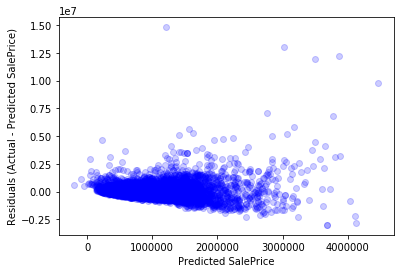

In [31]:
ac.homosdt_check_fig(kh_df4, model4)

In [32]:
ac.homosdt_check_test(kh_df4, model4)

Lagrange Multiplier p-value: 6.675472165236288e-270
F-statistic p-value: 2.3420438341964095e-277


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [33]:
ac.independence_check(kh_df4)

        VIF         feature
0  4.778308   SqFtTotLiving
1  3.467263  SqlTotalGarage
2  2.255932        is_porch
3  1.029119   is_waterfront


VIF needs to be smaller than 5.


#### Model4 interpretation:
After adding is_waterfront as new feature, the r squared in model4 increased to 0.426. The p value of the coefficient of is_waterfront is smaller than 0.01. It indicates that if a house near waterfront significantly increases the sale price.

The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.5 - Model5: add nuisance_bool as new feature.

Adding nuisance_bool to test if the presence of nuisance effect the house sale price.

In [34]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage',  'is_waterfront', 'is_porch', 'nuisance_bool']

df = king_house_2019

kh_df5 = ac.create_df(df, columns)
model5 = ac.create_model(kh_df5)

In [35]:
ac.model_summary(model5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     2960.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:00   Log-Likelihood:            -2.8754e+05
No. Observations:               19877   AIC:                         5.751e+05
Df Residuals:                   19871   BIC:                         5.751e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.499e+04   8317.934      1.802      0.072   -1317.047    3.13e+04
X[0]         400.6428      4.136     96.878      0.000     392.537     408.749
X[1]        -288.4053     13.616    -21.181      0.000    -315.094    -261.716
X[2]        1.209e+06   2.59e+04     46.760      0.000    1.16e+06    1.26e+06
X[3]        1786.1789   6912.606      0.258      0.796   -1.18e+04    1.53e+04
X[4]        4.712e+04   8761.874      5.378      0.000    2.99e+04    6.43e+04
==============================================================================
Omnibus:                    26536.698   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20937493.769
Skew:                           7.100   Prob(JB):                         0.00
Kurtosis:                     161.363   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model5 Evaluation

In [36]:
ac.linearity_check(model5)

Rainbow statistic: 0.8887104338596992
Rainbow p-value: 0.9999999979278206


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [37]:
ac.normality_check(model5)
print("\n")
print(f"Prob(JB) is still smaller than 0.001 in model4.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


Prob(JB) is still smaller than 0.001 in model4.


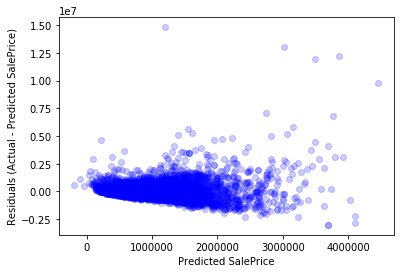

In [38]:
ac.homosdt_check_fig(kh_df5, model5)

In [39]:
ac.homosdt_check_test(kh_df5, model5)

Lagrange Multiplier p-value: 3.9508263139520126e-269
F-statistic p-value: 1.1137824448999083e-276


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [40]:
ac.independence_check(kh_df5)

        VIF         feature
0  5.029808   SqFtTotLiving
1  3.500070  SqlTotalGarage
2  1.029119   is_waterfront
3  2.257445        is_porch
4  1.153011   nuisance_bool


VIF needs to be smaller than 5.


#### Model5 interpretation:
After adding a new feature, model explains 0.1% more variance of the sale price. Though the p value of the coeeficient of is_porch is smaller than 0.01, the effect size is very small. In addition, houses with nuisance have a higher mean compared to house without nuisance. The coefficient is 4712, and the p value is smaller than 0.01.

The boxplot above showed that the mean difference between having nuisance and not having nuisance is very small. 

The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.6 - Model6: Remove features and add LakeWashington as a new feature.

Due to adding these two features, is_porch and nuisance_bool, did not increase the r squared value, they are removed from the model6. A new feature LakeWashington is added in as a new feature. Model6 will test if house having a lake washington view will influence the sale price. 

In [41]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage',  'is_waterfront', 'LakeWashington']
df = king_house_2019

kh_df6 = ac.create_df(df, columns)
model6 = ac.create_model(kh_df6)

In [42]:
ac.model_summary(model6)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     4577.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:01   Log-Likelihood:            -2.8658e+05
No. Observations:               19877   AIC:                         5.732e+05
Df Residuals:                   19872   BIC:                         5.732e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.384e+04   7587.751      7.095      0.000     3.9e+04    6.87e+04
X[0]         372.3426      3.856     96.569      0.000     364.785     379.900
X[1]        -249.3294     12.942    -19.266      0.000    -274.696    -223.963
X[2]        8.779e+05   2.57e+04     34.135      0.000    8.27e+05    9.28e+05
X[3]        3.657e+05   8091.220     45.199      0.000     3.5e+05    3.82e+05
==============================================================================
Omnibus:                    25275.137   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17708622.909
Skew:                           6.474   Prob(JB):                         0.00
Kurtosis:                     148.651   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model6 Evaluation

In [43]:
ac.linearity_check(model6)

Rainbow statistic: 0.8455892636454854
Rainbow p-value: 0.9999999999999999


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [44]:
ac.normality_check(model6)

print("\n")
print(f"The Prob(JB) is < 0.01, therefore, the normality was violated.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


The Prob(JB) is < 0.01, therefore, the normality was violated.


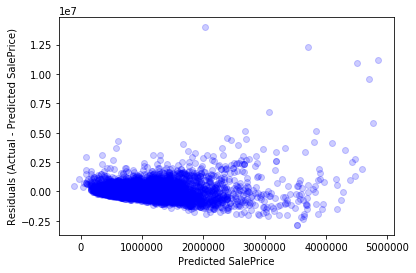

In [45]:
ac.homosdt_check_fig(kh_df6, model6)

In [46]:
ac.homosdt_check_test(kh_df6, model6)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [47]:
ac.independence_check(kh_df6)

        VIF         feature
0  3.610064   SqFtTotLiving
1  3.490947  SqlTotalGarage
2  1.120874   is_waterfront
3  1.147019  LakeWashington


VIF needs to be smaller than 5.


#### Model6 interpretation:
After adding LakeWashington as a new feature, the R-squared increased to 0.48. The p value of the coeeficient of lakewashingto is smaller than 0.01, and the effect size is sizable small. It indicates that having a view of lakewashington increases the sale price.

The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.

#### 3.7 - Model7: add total PortchTotal as a new feature

Even though if having a porch does not effect the sale price, it is worth adding the total sqrt porch as a new feature.

In [48]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage',  
           'is_waterfront', 'LakeWashington', 'PorchTotal']
df = king_house_2019

kh_df7 = ac.create_df(df, columns)
model7 = ac.create_model(kh_df7)

In [49]:
ac.model_summary(model7)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     3698.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:28:01   Log-Likelihood:            -2.8654e+05
No. Observations:               19877   AIC:                         5.731e+05
Df Residuals:                   19871   BIC:                         5.731e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.277e+04   7626.009      8.231      0.000    4.78e+04    7.77e+04
X[0]         360.1006      4.049     88.940      0.000     352.165     368.037
X[1]        -247.2355     12.913    -19.146      0.000    -272.547    -221.924
X[2]        8.608e+05   2.57e+04     33.470      0.000     8.1e+05    9.11e+05
X[3]        3.686e+05   8077.782     45.629      0.000    3.53e+05    3.84e+05
X[4]         213.7576     22.056      9.692      0.000     170.527     256.989
==============================================================================
Omnibus:                    25238.875   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17837129.346
Skew:                           6.452   Prob(JB):                         0.00
Kurtosis:                     149.187   Cond. No.                     1.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model7 Evaluation

In [50]:
ac.linearity_check(model7)

Rainbow statistic: 0.8502599360093266
Rainbow p-value: 0.9999999999999997


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [51]:
ac.normality_check(model7)

print("\n")
print(f"The Prob(JB) is < 0.01, therefore, the normality was violated.")

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


The Prob(JB) is < 0.01, therefore, the normality was violated.


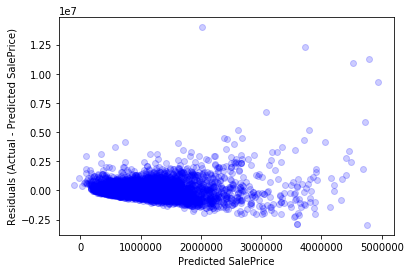

In [52]:
ac.homosdt_check_fig(kh_df7, model7)

In [53]:
ac.homosdt_check_test(kh_df7, model7)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [54]:
ac.independence_check(kh_df7)

        VIF         feature
0  4.071801   SqFtTotLiving
1  3.492255  SqlTotalGarage
2  1.126052   is_waterfront
3  1.147843  LakeWashington
4  1.433126      PorchTotal


VIF needs to be smaller than 5.


#### Model7 interpretation:
After adding PorchToal as a new feature, the R-squared increased only 0.002. The p value of the coeeficient of PorchTotal is smaller than 0.01, but the effect size is very small. 

The results of the model evaluation are still not promising. The assumtion of normality and homoscadasticity are not met.